In [11]:
import mysql.connector
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp
from IPython.display import display
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.decision_tree import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
import spacy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from numpy import argsort
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.pipeline import *


In [12]:
creds = ["uktuserdaroglu","Vacy4201(Pri","172.20.20.4","hgo",3306]
#Connection to the database
host = creds[2]
user = creds[0]
password = creds[1]
database = creds[3]
port = creds[4]
mydb = mysql.connector.connect(host=host, user=user, database=database, port=port, password=password, auth_plugin='mysql_native_password')
mycursor = mydb.cursor()

#Safecheck to guarantee that the connection worked
mycursor.execute('SHOW TABLES;')
print(f"Tables: {mycursor.fetchall()}")
print(mydb.connection_id) #it'll give connection_id,if got connected

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
600


In [13]:
alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)

/Users/utkuserdaroglu/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [14]:
data= pre_process(alertP1)

/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/utkuserdaroglu/Desktop/utkubranch/PBL-HGO/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [15]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1609 entries, 630 to 1227
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1609 non-null   object        
 1   PROCESSO                     1609 non-null   object        
 2   COD_REFERENCIA               1609 non-null   object        
 3   COD_PZ                       1609 non-null   object        
 4   COD_UNID_SAUDE_PROV          1609 non-null   int64         
 5   UNID_PROV                    1609 non-null   object        
 6   TIPO_UNID                    1609 non-null   object        
 7   COD_CTH_PRIOR                1609 non-null   object        
 8   CTH_PRIOR                    1609 non-null   object        
 9   COD_MOTIVO_RECUSA            1609 non-null   int64         
 10  DES_MOTIVO_RECUSA            1609 non-null   object        
 11  COD_ESPECIALIDADE            1609 non-nul

In [16]:
# Split data into train and test
import math
datasorted = data.sort_values(by='DATA_RECEPCAO')

    # calculate the index for the split
split_index = math.ceil(0.8 * len(datasorted))

    # split the data frame into test and train sets
train_set = datasorted.iloc[:split_index]
test_set= datasorted.iloc[split_index:]

In [17]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 630 to 629
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    1288 non-null   object        
 1   PROCESSO                     1288 non-null   object        
 2   COD_REFERENCIA               1288 non-null   object        
 3   COD_PZ                       1288 non-null   object        
 4   COD_UNID_SAUDE_PROV          1288 non-null   int64         
 5   UNID_PROV                    1288 non-null   object        
 6   TIPO_UNID                    1288 non-null   object        
 7   COD_CTH_PRIOR                1288 non-null   object        
 8   CTH_PRIOR                    1288 non-null   object        
 9   COD_MOTIVO_RECUSA            1288 non-null   int64         
 10  DES_MOTIVO_RECUSA            1288 non-null   object        
 11  COD_ESPECIALIDADE            1288 non-null

In [29]:
test_set.info()
test_set.columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 321 entries, 1765 to 1227
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID_DOENTE                    321 non-null    object        
 1   PROCESSO                     321 non-null    object        
 2   COD_REFERENCIA               321 non-null    object        
 3   COD_PZ                       321 non-null    object        
 4   COD_UNID_SAUDE_PROV          321 non-null    int64         
 5   UNID_PROV                    321 non-null    object        
 6   TIPO_UNID                    321 non-null    object        
 7   COD_CTH_PRIOR                321 non-null    object        
 8   CTH_PRIOR                    321 non-null    object        
 9   COD_MOTIVO_RECUSA            321 non-null    int64         
 10  DES_MOTIVO_RECUSA            321 non-null    object        
 11  COD_ESPECIALIDADE            321 non-null

Index(['ID_DOENTE', 'PROCESSO', 'COD_REFERENCIA', 'COD_PZ',
       'COD_UNID_SAUDE_PROV', 'UNID_PROV', 'TIPO_UNID', 'COD_CTH_PRIOR',
       'CTH_PRIOR', 'COD_MOTIVO_RECUSA', 'DES_MOTIVO_RECUSA',
       'COD_ESPECIALIDADE', 'DES_ESPECIALIDADE', 'agrupadora',
       'OUTRA_ENTIDADE', 'DATA_RECEPCAO', 'DATA_ENVIO', 'DATA_RETORNO',
       'NUM_TAXA', 'ESTADO', 'DATA_MARCACAO', 'DATA_REALIZACAO', 'OBSERVACOES',
       'Mês_entrada', 'Ano_entrada', 'trata data recusa', 'resume saída',
       'mês_saida', 'ano_saida', 'Texto', 'clean_text', 'result',
       'text_length', 'symptom_1', 'symptom_0', 'exam_identified',
       'comorbidity_identified', 'medication_level_1', 'medication_level_2',
       'medication_level_3', 'medication_count', 'medication_concentration',
       'medication1_concentration', 'medication2_concentration',
       'medication3_concentration', 'symptoms_count', 'symptoms_concentration',
       'symptoms0_concentration', 'symptoms1_concentration',
       'exams_concentra

In [54]:

window1= 2  # Adjust the window size according to your preference
window2=2
train_set_monthly = train_set.resample('M', on='DATA_RECEPCAO').mean()
train_set_monthly['moving_avg'] = train_set_monthly['result'].rolling(window1).mean()

test_set_monthly = test_set.resample('M', on='DATA_RECEPCAO').mean()
test_set_monthly['moving_avg'] = test_set_monthly['result'].rolling(window2).mean()


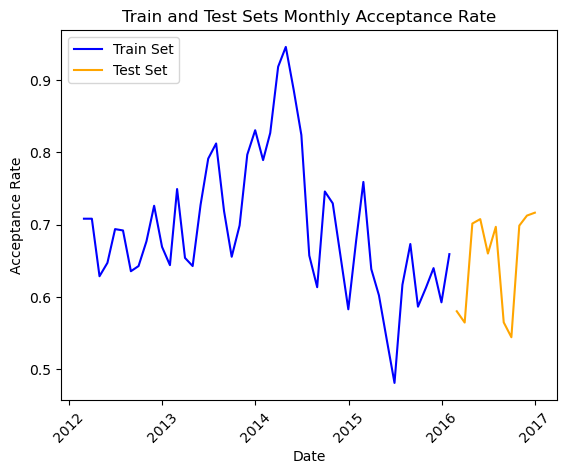

In [55]:
plt.plot(train_set_monthly.index, train_set_monthly['moving_avg'], c='blue', label='Train Set')
plt.plot(test_set_monthly.index, test_set_monthly['moving_avg'], c='orange', label='Test Set')

plt.xlabel('Date')
plt.ylabel('Acceptance Rate')
plt.legend(loc='upper left')
plt.title('Train and Test Sets Monthly Acceptance Rate')
plt.xticks(rotation=45)
plt.show()
